In [3]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

from Environment.env_v9 import *
from Functions.visualization_functions import *

In [27]:
# Configuration of the network
with open('./Config/network_config_v1.json') as file:
    network_config = file.read()

EP_LENGTH = 100

In [28]:
def load_config(config_file):

    with open(config_file, "r") as f:
        config = json.load(f)
    return config

def make_env(config_file="config.json"):

    config = load_config(config_file)

    env = SS_Mngmt_Env(
        network_config=network_config,
        EP_LENGTH=EP_LENGTH,
        render_mode="human",
        model_type="PPO",
        stockout_cost=config["stockout_cost"],
        order_cost=config["order_cost"],
        item_cost=config["item_cost"],
        stock_cost=config["stock_cost"],
        item_prize=config["item_prize"],
        progressive_stock_cost=config["progressive_stock_cost"],
        stock_out_max=config["stock_out_max"],
        order_quantities=config["order_quantities"],
        demand_mean=config["demand_mean"],
        demand_std=config["demand_std"],
        demand_noise=config["demand_noise"],
        demand_noise_std=config["demand_noise_std"],
        demand_prob=config["demand_prob"],
        extreme=True,
        seasonality=True,
        intermediate_reward=1000,
    )

    env = Monitor(env)

    return env

env = make_env("./Config/env_config_v0.json")
check_env(env, warn=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation order_queues has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [29]:
log_path = os.path.join('Training', 'Logs', 'PPO')
model_path = os.path.join('Training', 'Models', 'PPO')

In [30]:
# Load the study from training
with open("./Training/Tuning/PPO_optuna_study_2024-12-17_10_35.pkl", "rb") as f:
    study = pickle.load(f)

print("Best parameters from loaded study:", study.best_params)

Best parameters from loaded study: {'learning_rate': 0.00127288379031007, 'gamma': 0.99, 'ent_coef': 0.0003005395789688769, 'vf_coef': 0.6388443889380533, 'n_steps': 1024, 'batch_size': 16, 'clip_range': 0.3447477624953612}


In [31]:
vec_env = DummyVecEnv([lambda: make_env("./Config/env_config_v0.json")])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

# num_envs = 4
# env_config_path = "./Config/env_config_v0.json"

# vec_env = SubprocVecEnv([lambda: make_env(env_config_path) for _ in range(num_envs)])
# vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

best_params = study.best_params

# model = PPO(
#     "MultiInputPolicy", 
#     vec_env,
#     verbose=0,
#     learning_rate=best_params["learning_rate"],
#     gamma=best_params["gamma"],
#     clip_range=best_params["clip_range"],
#     ent_coef=best_params["ent_coef"],
#     vf_coef=best_params["vf_coef"],          
#     n_steps=best_params["n_steps"],
#     batch_size=best_params["batch_size"],
#     tensorboard_log=log_path,
#     )

model = PPO(
    "MultiInputPolicy", 
    vec_env,
    verbose=0,
    learning_rate=0.0003 ,
    gamma=0.99,
    clip_range=0.15,
    ent_coef=0.01,
    vf_coef=0.5,
    n_steps=2048,
    batch_size=64,
    tensorboard_log=log_path,
    )

In [32]:
model.learn(total_timesteps=800_000)

In [33]:
model.save(os.path.join(model_path, "PPO_SS_Mngmt_v4"))

In [34]:
# model.load(os.path.join(model_path, "PPO_SS_Mngmt_v3"))

In [58]:
# Evaluate the policy
episode_rewards, episode_lengths = evaluate_policy(model, vec_env, n_eval_episodes=20, render=False, return_episode_rewards=True)

output_data = [
    {
        "episode": i + 1,
        "score": episode_rewards[i],
        "timesteps": episode_lengths[i]
    }
    for i in range(len(episode_rewards))
]

output_file = "./Data/Evaluation/evaluation_results_ppo.json"
with open(output_file, "w") as file:
    json.dump(output_data, file)

print(f"Evaluation results saved to {output_file}")
print(f"Mean score: {np.mean(episode_rewards)}")
print(f"Mean timesteps: {np.mean(episode_lengths)}")

# print last episode
print("Last episode: ", output_data[-1])

Evaluation results saved to ./Data/Evaluation/evaluation_results_ppo.json
Mean score: 17937.2745
Mean timesteps: 85.65
Last episode:  {'episode': 20, 'score': 30807.08, 'timesteps': 100}


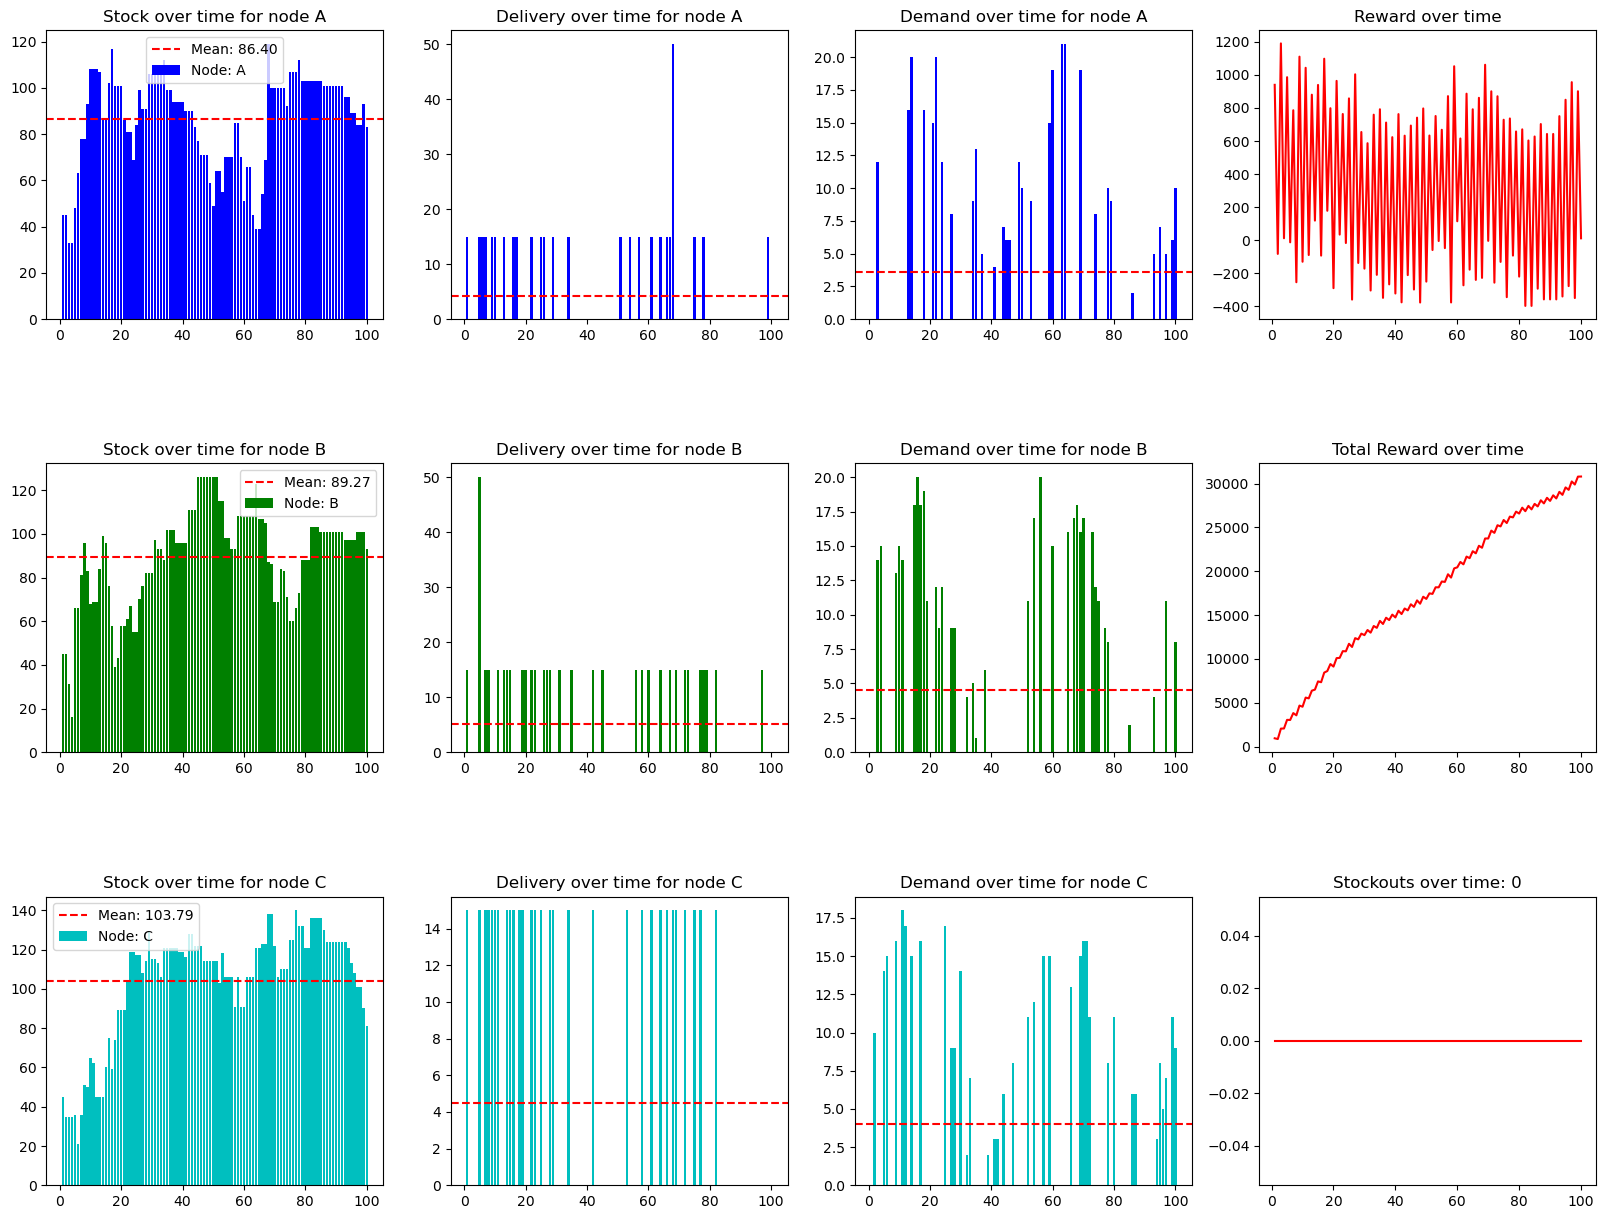

In [4]:
file = './Data/2024-12-17_environment_data_PPO.csv'
df = pd.read_csv(file)

plot_data(df)